In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import boxcox
from collections import Counter
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
import warnings

In [3]:
# loading the dataframes
imdb_full_info_df = pd.read_csv('imdb_full_info_df.csv')
inflation_df = pd.read_csv('inflation_data.csv')
cast_score_df = pd.read_csv('cast_score_df.csv')
rt_df = pd.read_csv('year_difference_Biagio_8_march_modif.csv', sep=';')

# Data Processing

In [4]:
# dropping irrelevant columns
rt_df.drop(['Unnamed: 0', 'release_date', 'budget', 'domestic_gross',
       'worldwide_gross', 'title', 'imdb_rating', 'cast_1', 'cast_2', 'cast_3',
       'runtime', 'genre', 'director', 'difference', 'Year_scraped'], axis=1, inplace=True)

In [5]:
# dropping irrelevant columns
imdb_full_info_df.drop(['release_date', 'domestic_gross', 'cast_1', 'cast_2', 'cast_3', 'movie_url', 'imdb_id',
       'director', 'rating_check', 'director.1'], axis=1, inplace=True)

In [6]:
# dropping irrelevant columns
cast_score_df.drop(['movie_title', 'cast_1_score', 'cast_2_score', 'cast_3_score'], axis=1, inplace=True)

In [7]:
# combining all 3 dataframes
df = pd.concat([imdb_full_info_df, rt_df, cast_score_df], axis=1)

In [8]:
# filtering out movies produced in 2000
df = df[df['release_year']>2000]

In [9]:
# resetting index
df.reset_index(drop=True, inplace=True)

In [10]:
# extracting runtime values
runtime = []
for i in df['runtime']:
    runtime.append(int(i[2:][:-2]))
    
df['runtime'] = runtime

In [11]:
# processing the inflation_df
inflation_df = inflation_df.sort_values('year', ascending=False)
inflation_df.drop(20, axis=0, inplace=True)
inflation_df.reset_index(inplace=True)
inflation_df.drop(columns=['index'], axis=1, inplace=True)

In [12]:
# calculating the compounded inflation rate for each year with 2019 as base year
for i in range(0, len(inflation_df)):
    if i == 0:
        inflation_df['dollar'][i] = 1
    else:
        inflation_df['dollar'][i] = inflation_df['dollar'][i-1]*(1+inflation_df['inflation'][i-1])

C:\Users\Bosco\AppData\Local\Temp/ipykernel_8996/4206754930.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflation_df['dollar'][i] = 1
C:\Users\Bosco\AppData\Local\Temp/ipykernel_8996/4206754930.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflation_df['dollar'][i] = inflation_df['dollar'][i-1]*(1+inflation_df['inflation'][i-1])


In [13]:
# storing the year and compounded rate in a dictionary
inflation_dict = pd.Series(inflation_df.dollar.values, index=inflation_df.year).to_dict()

In [14]:
# adjusting inflation for budget and worldwide_gross
budget_adj = []
worldwide_gross_adj = []

for i in range(0,len(df)):
    inflation_comp = inflation_dict[df['release_year'][i]]
    budget_adj.append(round(df['budget'][i]*inflation_comp))
    worldwide_gross_adj.append(round(df['worldwide_gross'][i]*inflation_comp))

df['budget_adj'] = budget_adj
df['worldwide_gross_adj'] = worldwide_gross_adj

In [15]:
df.drop(['budget', 'worldwide_gross', 'release_year'], axis=1, inplace=True)

In [16]:
# MPA_Ratings - removing space inide string
df['MPA_Ratings'] = df['MPA_Ratings'].str.strip()

In [17]:
# MPA_Ratings - correcting typos
df['MPA_Ratings'].replace({'PG_13':'PG-13'}, inplace=True)

In [18]:
# MPA_Ratings - naming the nulls
df['MPA_Ratings'].fillna(value='Unknown', inplace=True)

In [19]:
# original_language - categorizing american and non-american production
us_production = []
for i in df['original_language']:
    if i == 'English':
        us_production.append('Yes')
    else:
        us_production.append('No')

df['us_production'] = us_production

In [20]:
df.drop(['original_language'], axis=1, inplace=True)

In [21]:
# dropping null values
df.dropna(inplace=True)

In [22]:
# resetting index
df.reset_index(drop=True, inplace=True)

In [23]:
df.rename(columns={'MPA_Ratings': 'mpa_rating'}, inplace=True)

In [24]:
df

,title,imdb_rating,runtime,genre,tomatometer_score,audience_score_rt,mpa_rating,cast_score,budget_adj,worldwide_gross_adj,us_production
0,Avengers: Endgame,8.4,181,"['Action', 'Adventure', 'Drama', 'Sci-Fi']",94.0,90.0,PG-13,761,400000000,2797800564,Yes
1,Pirates of the Caribbean: On Stranger Tides,6.6,137,"['Action', 'Adventure', 'Fantasy']",33.0,54.0,PG-13,308,430707129,1188380976,Yes
2,Avengers: Age of Ultron,7.3,141,"['Action', 'Adventure', 'Sci-Fi']",76.0,83.0,PG-13,599,393679419,1504952267,Yes
3,Star Wars Episode VII: The Force Awakens,7.9,138,"['Action', 'Adventure', 'Sci-Fi']",93.0,85.0,PG-13,0,330043568,2226840424,Yes
4,Avengers: Infinity War,8.5,149,"['Action', 'Adventure', 'Sci-Fi']",85.0,91.0,PG-13,887,305280000,2084410886,Yes
...,...,...,...,...,...,...,...,...,...,...,...
3120,"Gandhi, My Father",7.3,136,"['Biography', 'Drama', 'History']",47.0,71.0,Unknown,0,6164349,2484238,No
3121,Tucker & Dale vs. Evil,7.5,89,"['Comedy', 'Horror']",85.0,85.0,R,0,5682152,6223994,Yes
3122,Redacted,6.1,90,"['Crime', 'Thriller', 'War']",45.0,45.0,R,0,6164349,1061902,Yes
3123,Rudderless,7.4,105,"['Comedy', 'Drama', 'Music']",64.0,83.0,R,0,5399340,631182,Yes


array([[<AxesSubplot:title={'center':'imdb_rating'}>,
        <AxesSubplot:title={'center':'runtime'}>,
        <AxesSubplot:title={'center':'tomatometer_score'}>],
       [<AxesSubplot:title={'center':'audience_score_rt'}>,
        <AxesSubplot:title={'center':'cast_score'}>,
        <AxesSubplot:title={'center':'budget_adj'}>],
       [<AxesSubplot:title={'center':'worldwide_gross_adj'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

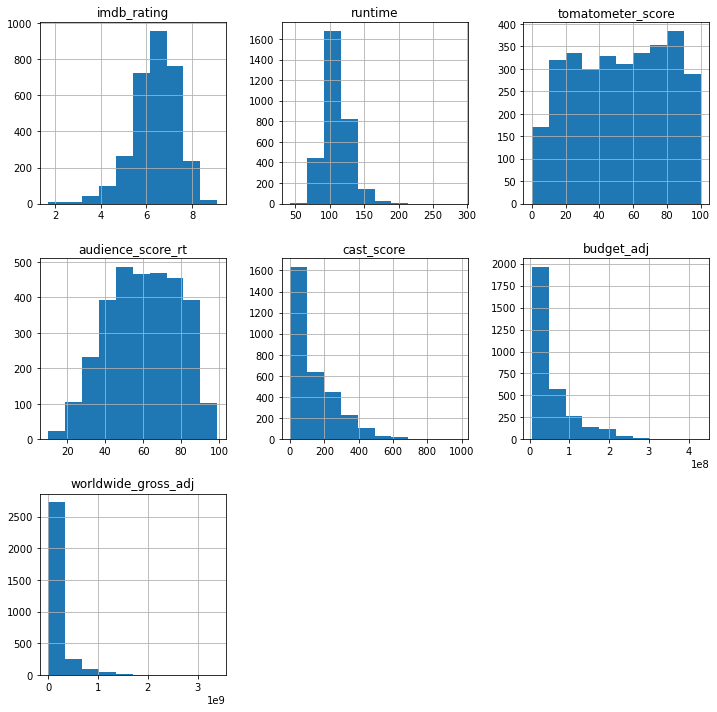

In [25]:
df.hist(figsize=(12,12))

Text(0.5, 1.0, 'runtime')

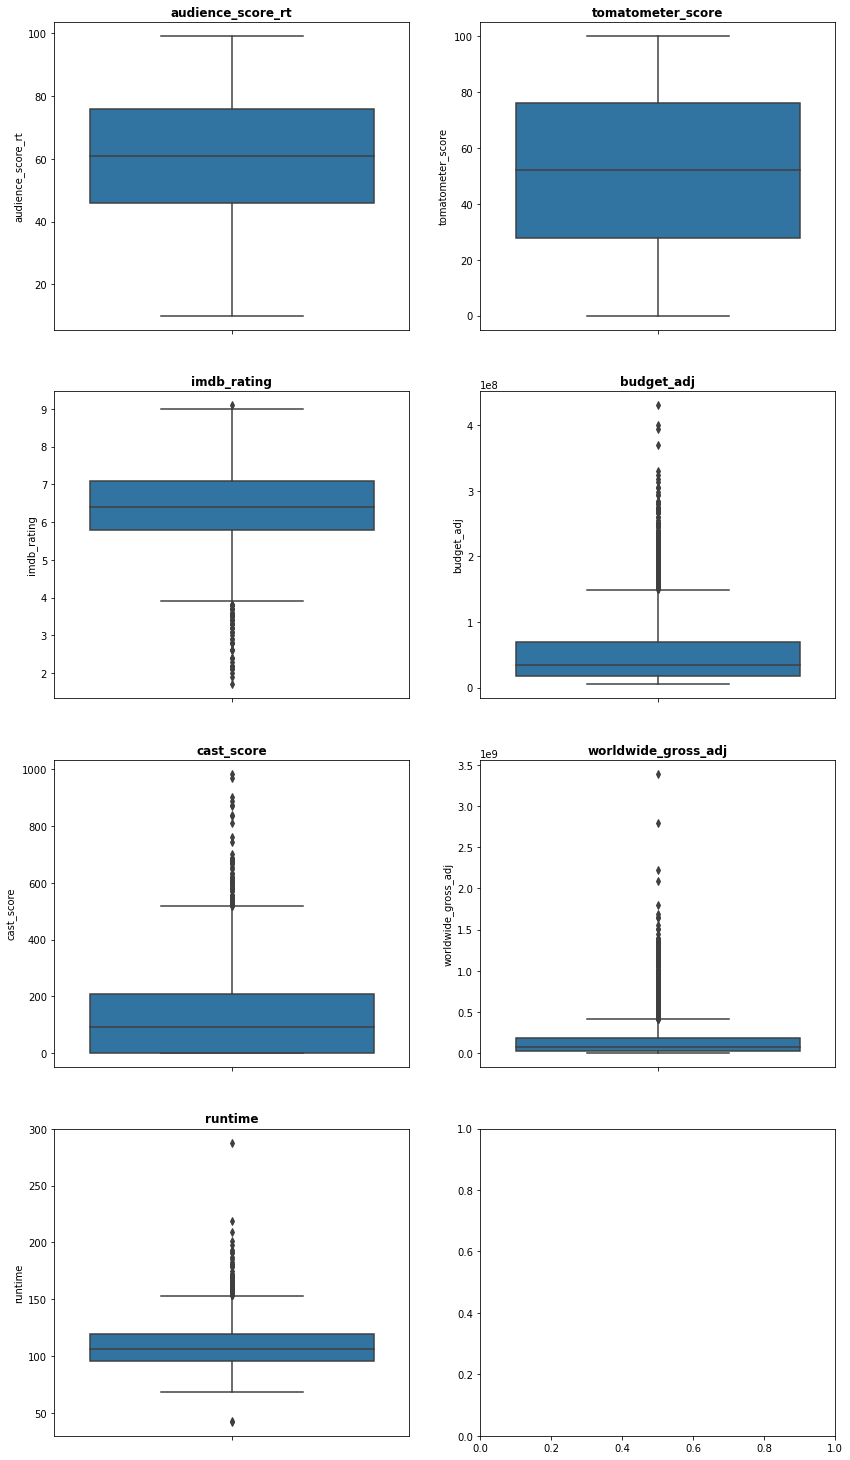

In [26]:
#use boxplot to see outlier distributions on numerical columns
fig2, ax2 = plt.subplots(4,2, figsize=(14,26))
sns.boxplot(y=df['audience_score_rt'], ax = ax2[0,0])
ax2[0,0].set_title('audience_score_rt', fontweight='bold')
sns.boxplot(y=df['tomatometer_score'], ax = ax2[0,1])
ax2[0,1].set_title('tomatometer_score', fontweight='bold')
sns.boxplot(y=df['imdb_rating'], ax = ax2[1,0])
ax2[1,0].set_title('imdb_rating', fontweight='bold')
sns.boxplot(y=df['budget_adj'], ax = ax2[1,1])
ax2[1,1].set_title('budget_adj', fontweight='bold')
sns.boxplot(y=df['cast_score'], ax = ax2[2,0])
ax2[2,0].set_title('cast_score', fontweight='bold')
sns.boxplot(y=df['worldwide_gross_adj'], ax = ax2[2,1])
ax2[2,1].set_title('worldwide_gross_adj', fontweight='bold')
sns.boxplot(y=df['runtime'], ax = ax2[3,0])
ax2[3,0].set_title('runtime', fontweight='bold')

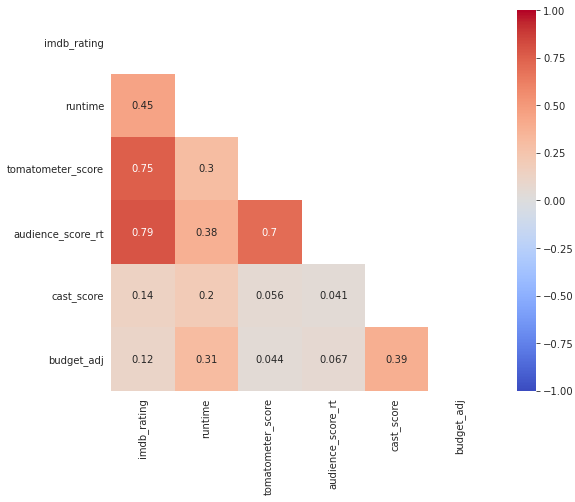

In [27]:
# checking multicollinearity
corr = df.drop('worldwide_gross_adj', axis=1).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

# Modelling

In [28]:
# function for modelling
models = {
    'LR': LinearRegression(),
    'Lasso': Lasso(alpha=0.1),
    'Ridge': Ridge(alpha=1.0),
    'KNN': KNeighborsRegressor(n_neighbors=15)
}
temp = pd.DataFrame(columns=['r2_train','r2_test','adj_r2_train','adj_r2_test'],
                       index=['LR', 'Lasso', 'Ridge', 'KNN'])
def apply_model(models):
    global features_importance
    for model_name, model in models.items():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 100)
       
        pt_X = PowerTransformer(method='box-cox', standardize=False)
        pt_X = pt_X.fit(X_train['budget_adj'].to_numpy().reshape(-1,1))
        budget_adj_train_tf = pt_X.transform(X_train['budget_adj'].to_numpy().reshape(-1,1))
        budget_adj_test_tf = pt_X.transform(X_test['budget_adj'].to_numpy().reshape(-1,1))

        pt_y = PowerTransformer(method='box-cox', standardize=False)
        pt_y = pt_y.fit(y_train.to_numpy().reshape(-1,1))
        y_train = pt_y.transform(y_train.to_numpy().reshape(-1,1))
        y_test = pt_y.transform(y_test.to_numpy().reshape(-1,1))
        
        X_train['budget_adj'] = budget_adj_train_tf
        X_test['budget_adj'] = budget_adj_test_tf
        
        std_scaler = StandardScaler().fit(X_train)
        X_train_scaled = std_scaler.transform(X_train)
        X_test_scaled = std_scaler.transform(X_test)
       
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
                
        temp.loc[model_name, 'r2_train'] = model.score(X_train_scaled, y_train)
        temp.loc[model_name, 'r2_test'] = model.score(X_test_scaled, y_test)
        temp.loc[model_name, 'adj_r2_train'] = 1-((1-model.score(X_train_scaled, y_train))*(len(y_train)-1)/((len(y_train)-X_train.shape[1]-1)))
        temp.loc[model_name, 'adj_r2_test'] = 1-((1-model.score(X_test_scaled, y_test))*(len(y_test)-1)/((len(y_test)-X_test.shape[1]-1)))
    
        if model_name == 'LR':
            features_importance = pd.DataFrame(data = {
                'Attribute': X_train.columns.tolist(),
                'Importance': abs(model.coef_).tolist()[0]
                })
            features_importance = features_importance.sort_values(by='Importance', ascending=False)
        
          
    return temp, features_importance

# Modelling
### Only numericals

In [29]:
# X, y split
## Only numericals
X = df.drop(columns=['title', 'genre', 'mpa_rating', 'worldwide_gross_adj', 'us_production'], axis=1)
y = df['worldwide_gross_adj']

In [30]:
apply_model(models)

(       r2_train   r2_test adj_r2_train adj_r2_test
 LR     0.542968    0.5399     0.541868    0.535433
 Lasso  0.542334  0.538316     0.541233    0.533834
 Ridge  0.542968  0.539887     0.541868     0.53542
 KNN    0.592964  0.535112     0.591984    0.530598,
            Attribute  Importance
 5         budget_adj    7.675920
 3  audience_score_rt    2.266764
 2  tomatometer_score    1.102638
 4         cast_score    0.777508
 1            runtime    0.558346
 0        imdb_rating    0.242922)

# Modelling
### Only numericals while dropping imdb_rating (multicollinearity)

In [31]:
# X, y split
## Only numericals - dropping imdb_rating
X = df.drop(columns=['title', 'genre', 'mpa_rating', 'worldwide_gross_adj', 'us_production', 'imdb_rating'], axis=1)
y = df['worldwide_gross_adj']

In [32]:
apply_model(models)

(       r2_train   r2_test adj_r2_train adj_r2_test
 LR     0.542841  0.540581     0.541925     0.53687
 Lasso  0.542334  0.538316     0.541417    0.534587
 Ridge  0.542841   0.54056     0.541924    0.536849
 KNN    0.592913  0.528331     0.592097    0.524521,
            Attribute  Importance
 4         budget_adj    7.672262
 2  audience_score_rt    2.152807
 1  tomatometer_score    1.011307
 3         cast_score    0.760511
 0            runtime    0.591641)

# Modelling
### Only numericals while dropping imdb_rating and tomatometer_score (multicollinearity)

In [33]:
# X, y split
## Only numericals - dropping imdb_rating and tomatometer_score
X = df.drop(columns=['title', 'genre', 'mpa_rating', 'worldwide_gross_adj', 'us_production', 'imdb_rating', 'tomatometer_score'], axis=1)
y = df['worldwide_gross_adj']

In [34]:
apply_model(models)

(       r2_train   r2_test adj_r2_train adj_r2_test
 LR     0.538802  0.538785     0.538062    0.535809
 Lasso   0.53832  0.536425      0.53758    0.533434
 Ridge  0.538802  0.538764     0.538062    0.535789
 KNN    0.591031  0.517855     0.590376    0.514744,
            Attribute  Importance
 3         budget_adj    7.602061
 1  audience_score_rt    2.833405
 2         cast_score    0.816709
 0            runtime    0.526991)

# Modelling
### Numericals and categorials while dropping imdb_rating and filtering mpa_ratings and genre

In [35]:
df_all = df.drop(columns=['title', 'imdb_rating'], axis=1)
df_all

,runtime,genre,tomatometer_score,audience_score_rt,mpa_rating,cast_score,budget_adj,worldwide_gross_adj,us_production
0,181,"['Action', 'Adventure', 'Drama', 'Sci-Fi']",94.0,90.0,PG-13,761,400000000,2797800564,Yes
1,137,"['Action', 'Adventure', 'Fantasy']",33.0,54.0,PG-13,308,430707129,1188380976,Yes
2,141,"['Action', 'Adventure', 'Sci-Fi']",76.0,83.0,PG-13,599,393679419,1504952267,Yes
3,138,"['Action', 'Adventure', 'Sci-Fi']",93.0,85.0,PG-13,0,330043568,2226840424,Yes
4,149,"['Action', 'Adventure', 'Sci-Fi']",85.0,91.0,PG-13,887,305280000,2084410886,Yes
...,...,...,...,...,...,...,...,...,...
3120,136,"['Biography', 'Drama', 'History']",47.0,71.0,Unknown,0,6164349,2484238,No
3121,89,"['Comedy', 'Horror']",85.0,85.0,R,0,5682152,6223994,Yes
3122,90,"['Crime', 'Thriller', 'War']",45.0,45.0,R,0,6164349,1061902,Yes
3123,105,"['Comedy', 'Drama', 'Music']",64.0,83.0,R,0,5399340,631182,Yes


In [36]:
df_eng = df_all
df_eng

,runtime,genre,tomatometer_score,audience_score_rt,mpa_rating,cast_score,budget_adj,worldwide_gross_adj,us_production
0,181,"['Action', 'Adventure', 'Drama', 'Sci-Fi']",94.0,90.0,PG-13,761,400000000,2797800564,Yes
1,137,"['Action', 'Adventure', 'Fantasy']",33.0,54.0,PG-13,308,430707129,1188380976,Yes
2,141,"['Action', 'Adventure', 'Sci-Fi']",76.0,83.0,PG-13,599,393679419,1504952267,Yes
3,138,"['Action', 'Adventure', 'Sci-Fi']",93.0,85.0,PG-13,0,330043568,2226840424,Yes
4,149,"['Action', 'Adventure', 'Sci-Fi']",85.0,91.0,PG-13,887,305280000,2084410886,Yes
...,...,...,...,...,...,...,...,...,...
3120,136,"['Biography', 'Drama', 'History']",47.0,71.0,Unknown,0,6164349,2484238,No
3121,89,"['Comedy', 'Horror']",85.0,85.0,R,0,5682152,6223994,Yes
3122,90,"['Crime', 'Thriller', 'War']",45.0,45.0,R,0,6164349,1061902,Yes
3123,105,"['Comedy', 'Drama', 'Music']",64.0,83.0,R,0,5399340,631182,Yes


In [37]:
# filtering out insignificant MPA_Ratings
df_eng = df_eng[(df_eng['mpa_rating'] != df_eng['mpa_rating'].value_counts()[df_eng['mpa_rating'].value_counts()<10].index[0]) & (df_eng['mpa_rating'] != df_eng['mpa_rating'].value_counts()[df_eng['mpa_rating'].value_counts()<10].index[1])]

In [38]:
# filtering out insignificant genre
df_eng = df_eng[~df_eng.genre.str.contains('Short')]

In [39]:
df_eng.reset_index(drop=True, inplace=True)

In [40]:
# one hot encoding for genre (multiple values)
x1 = df_eng['genre'].apply(eval)
x1 = x1.apply(Counter)
x1 = pd.json_normalize(x1)
x1 = x1.replace(np.nan, 0)
x1 = x1.astype('int')

In [41]:
df_eng.drop(['genre'], axis=1, inplace=True)

In [42]:
df_eng_num = df_eng._get_numeric_data()
df_eng_num

,runtime,tomatometer_score,audience_score_rt,cast_score,budget_adj,worldwide_gross_adj
0,181,94.0,90.0,761,400000000,2797800564
1,137,33.0,54.0,308,430707129,1188380976
2,141,76.0,83.0,599,393679419,1504952267
3,138,93.0,85.0,0,330043568,2226840424
4,149,85.0,91.0,887,305280000,2084410886
...,...,...,...,...,...,...
3114,136,47.0,71.0,0,6164349,2484238
3115,89,85.0,85.0,0,5682152,6223994
3116,90,45.0,45.0,0,6164349,1061902
3117,105,64.0,83.0,0,5399340,631182


In [43]:
df_eng_cat = df_eng.select_dtypes('object')
df_eng_cat

,mpa_rating,us_production
0,PG-13,Yes
1,PG-13,Yes
2,PG-13,Yes
3,PG-13,Yes
4,PG-13,Yes
...,...,...
3114,Unknown,No
3115,R,Yes
3116,R,Yes
3117,R,Yes


In [44]:
df_eng_cat = pd.get_dummies(df_eng_cat, drop_first=True)

In [45]:
df_combined = pd.concat([df_eng_num, df_eng_cat, x1], axis=1)
df_combined

,runtime,tomatometer_score,audience_score_rt,cast_score,budget_adj,worldwide_gross_adj,mpa_rating_NR,mpa_rating_PG,mpa_rating_PG-13,mpa_rating_R,...,Mystery,Crime,Western,History,Sport,Horror,Music,War,Biography,Documentary
0,181,94.0,90.0,761,400000000,2797800564,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,137,33.0,54.0,308,430707129,1188380976,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,141,76.0,83.0,599,393679419,1504952267,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,138,93.0,85.0,0,330043568,2226840424,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,149,85.0,91.0,887,305280000,2084410886,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3114,136,47.0,71.0,0,6164349,2484238,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3115,89,85.0,85.0,0,5682152,6223994,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3116,90,45.0,45.0,0,6164349,1061902,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
3117,105,64.0,83.0,0,5399340,631182,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [47]:
# X, y split
## Numericals and categoricals - filtering mpa_ratings and genre
X = df_combined.drop(columns=['worldwide_gross_adj'], axis=1)
y = df_combined['worldwide_gross_adj']

In [48]:
apply_model(models)

(       r2_train   r2_test adj_r2_train adj_r2_test
 LR     0.627582  0.610364     0.622741    0.589267
 Lasso  0.625638  0.612009     0.620772    0.591001
 Ridge  0.627582  0.610359     0.622741    0.589262
 KNN    0.532611  0.474563     0.526536    0.446113,
              Attribute  Importance
 4           budget_adj    7.223226
 2    audience_score_rt    3.030546
 27              Horror    1.880342
 13               Drama    1.803842
 1    tomatometer_score    1.278319
 3           cast_score    1.271885
 0              runtime    0.943061
 8         mpa_rating_R    0.893523
 20              Comedy    0.794520
 18              Family    0.772961
 9   mpa_rating_Unknown    0.767301
 23               Crime    0.709139
 24             Western    0.688682
 26               Sport    0.559059
 30           Biography    0.539698
 29                 War    0.525444
 25             History    0.482039
 7     mpa_rating_PG-13    0.470933
 16            Thriller    0.362012
 10   us_production

# Modelling
### Numericals and categorials while dropping imdb_rating

In [49]:
df_all2 = df_all

In [50]:
# one hot encoding for genre (multiple values)
x2 = df_all2['genre'].apply(eval)
x2 = x2.apply(Counter)
x2 = pd.json_normalize(x2)
x2 = x2.replace(np.nan, 0)
x2 = x2.astype('int')

In [51]:
df_all2.drop(['genre'], axis=1, inplace=True)

In [52]:
df_all2.reset_index(drop=True, inplace=True)

In [53]:
df_num2 = df_all2._get_numeric_data()
df_num2

,runtime,tomatometer_score,audience_score_rt,cast_score,budget_adj,worldwide_gross_adj
0,181,94.0,90.0,761,400000000,2797800564
1,137,33.0,54.0,308,430707129,1188380976
2,141,76.0,83.0,599,393679419,1504952267
3,138,93.0,85.0,0,330043568,2226840424
4,149,85.0,91.0,887,305280000,2084410886
...,...,...,...,...,...,...
3120,136,47.0,71.0,0,6164349,2484238
3121,89,85.0,85.0,0,5682152,6223994
3122,90,45.0,45.0,0,6164349,1061902
3123,105,64.0,83.0,0,5399340,631182


In [54]:
df_cat2 = df_all2.select_dtypes('object')
df_cat2

,mpa_rating,us_production
0,PG-13,Yes
1,PG-13,Yes
2,PG-13,Yes
3,PG-13,Yes
4,PG-13,Yes
...,...,...
3120,Unknown,No
3121,R,Yes
3122,R,Yes
3123,R,Yes


In [55]:
df_cat2 = pd.get_dummies(df_cat2, drop_first=True)

In [56]:
df_combined2 = pd.concat([df_num2, df_cat2, x2], axis=1)

In [57]:
# X, y split
## Numericals and categoricals - no filtering
X = df_combined2.drop(columns=['worldwide_gross_adj'], axis=1)
y = df_combined2['worldwide_gross_adj']

In [58]:
apply_model(models)

(       r2_train   r2_test adj_r2_train adj_r2_test
 LR     0.625522   0.61181     0.620202    0.588743
 Lasso  0.622893  0.611265     0.617536    0.588166
 Ridge  0.625522  0.611809     0.620202    0.588742
 KNN    0.531005  0.491733     0.524344     0.46153,
              Attribute  Importance
 4           budget_adj    6.571075
 2    audience_score_rt    2.681068
 29              Horror    1.672184
 15               Drama    1.601950
 1    tomatometer_score    1.141409
 3           cast_score    1.126252
 9         mpa_rating_R    0.857325
 0              runtime    0.841484
 26             Western    0.642380
 22              Comedy    0.630332
 25               Crime    0.614072
 11  mpa_rating_Unknown    0.607969
 27             History    0.511303
 32           Biography    0.476042
 20              Family    0.463296
 31                 War    0.430531
 28               Sport    0.423321
 8     mpa_rating_PG-13    0.318054
 10     mpa_rating_TVMA    0.299585
 12   us_production

In [59]:
print(features_importance[features_importance['Importance']<0.2].Attribute.tolist())
print(len(features_importance[features_importance['Importance']<0.2].Attribute.tolist()))

['Adventure', 'Action', 'Music', 'Animation', 'Sci-Fi', 'Romance', 'mpa_rating_NC-17', 'Musical', 'Fantasy', 'mpa_rating_NR', 'Mystery', 'Documentary', 'mpa_rating_PG', 'Short']
14


# Modelling - Final
### Numericals and categorials while dropping imdb_rating and insiginificant features (<0.2)

In [60]:
df_combined4 = df_combined2.drop(['Adventure', 'Action', 'Music', 'Animation', 'Sci-Fi', 'Romance', 'mpa_rating_NC-17', 'Musical', 'Fantasy', 'mpa_rating_NR', 'Mystery', 'Documentary', 'mpa_rating_PG', 'Short'], axis=1)

In [61]:
# X, y split
## Numericals and categoricals - dropping imdb_rating and insignificant features
X = df_combined4.drop(columns=['worldwide_gross_adj'], axis=1)
y = df_combined4['worldwide_gross_adj']

In [62]:
apply_model(models)

(       r2_train   r2_test adj_r2_train adj_r2_test
 LR     0.624528   0.61175     0.621346    0.598229
 Lasso   0.62267  0.611184     0.619472    0.597643
 Ridge  0.624528  0.611751     0.621346     0.59823
 KNN    0.583817  0.536554      0.58029    0.520414,
              Attribute  Importance
 4           budget_adj    6.500696
 2    audience_score_rt    2.675125
 18              Horror    1.720836
 10               Drama    1.604144
 3           cast_score    1.151770
 1    tomatometer_score    1.146954
 6         mpa_rating_R    0.880995
 0              runtime    0.880342
 15             Western    0.634741
 13              Comedy    0.631350
 8   mpa_rating_Unknown    0.628725
 14               Crime    0.577814
 16             History    0.495023
 20           Biography    0.470364
 12              Family    0.428927
 19                 War    0.425697
 17               Sport    0.397689
 7      mpa_rating_TVMA    0.305706
 5     mpa_rating_PG-13    0.287230
 9    us_production

In [557]:
features_importance

,Attribute,Importance
4,budget_adj,6.500696
2,audience_score_rt,2.675125
18,Horror,1.720836
10,Drama,1.604144
3,cast_score,1.151770
1,tomatometer_score,1.146954
6,mpa_rating_R,0.880995
0,runtime,0.880342
15,Western,0.634741
13,Comedy,0.631350


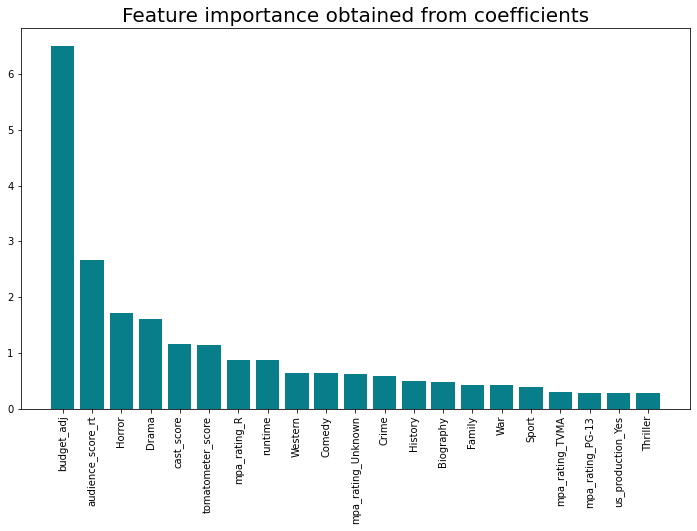

In [63]:
plt.figure(figsize=(12,7))
plt.bar(x=features_importance['Attribute'], height=features_importance['Importance'], color='#087E8B')
plt.title('Feature importance obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [69]:
df_all

,runtime,tomatometer_score,audience_score_rt,mpa_rating,cast_score,budget_adj,worldwide_gross_adj,us_production
0,181,94.0,90.0,PG-13,761,400000000,2797800564,Yes
1,137,33.0,54.0,PG-13,308,430707129,1188380976,Yes
2,141,76.0,83.0,PG-13,599,393679419,1504952267,Yes
3,138,93.0,85.0,PG-13,0,330043568,2226840424,Yes
4,149,85.0,91.0,PG-13,887,305280000,2084410886,Yes
...,...,...,...,...,...,...,...,...
3120,136,47.0,71.0,Unknown,0,6164349,2484238,No
3121,89,85.0,85.0,R,0,5682152,6223994,Yes
3122,90,45.0,45.0,R,0,6164349,1061902,Yes
3123,105,64.0,83.0,R,0,5399340,631182,Yes


### Removing Outliners

In [64]:
df_all3 = df_all

In [65]:
budget_Q1 = df_all3['budget_adj'].quantile(0.25)
budget_Q3 = df_all3['budget_adj'].quantile(0.75)
budget_IQR = budget_Q3 - budget_Q1    

In [66]:
budget_filter = (df_all3['budget_adj'] >= budget_Q1 - 2 * budget_IQR) & (df_all3['budget_adj'] <= budget_Q3 + 2 * budget_IQR)
df_all3 = df_all3[budget_filter] 

In [67]:
# filtering out insignificant MPA_Ratings
df_all3 = df_all3[(df_all3['mpa_rating'] != df_all3['mpa_rating'].value_counts()[df_all3['mpa_rating'].value_counts()<10].index[0]) & (df_all3['mpa_rating'] != df_all3['mpa_rating'].value_counts()[df_all3['mpa_rating'].value_counts()<10].index[1])]

In [68]:
# filtering out insignificant genre
df_all3 = df_all3[~df_all3.genre.str.contains('Short')]

AttributeError: 'DataFrame' object has no attribute 'genre'

In [291]:
# one hot encoding for genre (multiple values)
x3 = df_all3['genre'].apply(eval)
x3 = x3.apply(Counter)
x3 = pd.json_normalize(x3)
x3 = x3.replace(np.nan, 0)
x3 = x3.astype('int')

In [292]:
df_all3.drop(['genre'], axis=1, inplace=True)

In [293]:
df_all3.reset_index(drop=True, inplace=True)

In [294]:
df_num3 = df_all3._get_numeric_data()
df_num3

,runtime,tomatometer_score,audience_score_rt,cast_score,budget_adj,worldwide_gross_adj
0,123,79.0,45.0,474,175000000,1129727388
1,128,47.0,48.0,307,172992000,1331360683
2,112,46.0,48.0,203,170000000,353166307
3,132,42.0,83.0,71,170000000,383299915
4,122,61.0,92.0,63,170000000,401900040
...,...,...,...,...,...,...
2938,136,47.0,71.0,0,6164349,2484238
2939,89,85.0,85.0,0,5682152,6223994
2940,90,45.0,45.0,0,6164349,1061902
2941,105,64.0,83.0,0,5399340,631182


In [295]:
df_cat3 = df_all3.select_dtypes('object')
df_cat3

,mpa_rating,us_production
0,PG-13,Yes
1,PG-13,Yes
2,PG,Yes
3,PG-13,Yes
4,PG-13,Yes
...,...,...
2938,Unknown,No
2939,R,Yes
2940,R,Yes
2941,R,Yes


In [296]:
df_cat3 = pd.get_dummies(df_cat3, drop_first=True)

In [297]:
df_combined3 = pd.concat([df_num3, df_cat3, x3], axis=1)

In [298]:
# X, y split
## Numericals and categoricals - removing outliners in budget
X = df_combined3.drop(columns=['worldwide_gross_adj'], axis=1)
y = df_combined3['worldwide_gross_adj']

In [299]:
apply_model(models)

(       r2_train   r2_test adj_r2_train adj_r2_test
 LR     0.560299  0.556601     0.554237    0.531082
 Lasso  0.559213  0.556018     0.553135    0.530465
 Ridge  0.560299  0.556601     0.554237    0.531081
 KNN    0.472438  0.389459     0.465165     0.35432,
              Attribute    Importance
 4           budget_adj  1.079819e+01
 2    audience_score_rt  5.031851e+00
 27              Horror  2.843574e+00
 3           cast_score  1.867197e+00
 1    tomatometer_score  1.824161e+00
 24              Comedy  1.435051e+00
 0              runtime  1.191553e+00
 16            Thriller  7.459206e-01
 14              Family  5.561253e-01
 12           Adventure  4.662980e-01
 26             Mystery  1.978744e-01
 31         Documentary  4.705923e-02
 7     mpa_rating_PG-13  1.846047e-02
 5        mpa_rating_NR  7.105427e-15
 11              Action -5.749757e-02
 30               Music -6.792988e-02
 17             Musical -1.030861e-01
 6        mpa_rating_PG -1.534468e-01
 18             R

In [307]:
df_num4 = df_num2

In [308]:
df_cat4 = df_all2.select_dtypes('object').drop(['us_production'], axis=1)

In [312]:
df_cat4 = pd.get_dummies(df_cat4, drop_first=True)

In [313]:
df_combined4 = pd.concat([df_num4, df_cat4, x2], axis=1)

In [314]:
# X, y split
## Numericals and categoricals, dropping us_production
X = df_combined4.drop(columns=['worldwide_gross_adj'], axis=1)
y = df_combined4['worldwide_gross_adj']

In [315]:
apply_model(models)

(       r2_train   r2_test adj_r2_train adj_r2_test
 LR     0.625086  0.610816     0.619915    0.588389
 Lasso  0.622763  0.611044      0.61756    0.588629
 Ridge  0.625086  0.610818     0.619915     0.58839
 KNN    0.534229  0.492008     0.527805    0.462734,
              Attribute  Importance
 4           budget_adj    6.520125
 2    audience_score_rt    2.683950
 28              Horror    1.660467
 1    tomatometer_score    1.162460
 3           cast_score    1.100346
 0              runtime    0.872569
 21              Comedy    0.626705
 19              Family    0.456230
 8     mpa_rating_PG-13    0.286049
 17            Thriller    0.267023
 13           Adventure    0.193678
 5     mpa_rating_NC-17    0.116732
 23             Mystery    0.057981
 32         Documentary    0.042054
 33               Short    0.000000
 7        mpa_rating_PG   -0.030143
 6        mpa_rating_NR   -0.055326
 16             Fantasy   -0.071158
 20             Musical   -0.088186
 18           Anima